# Factor Analysis

In [1]:
# Debug magic:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os

from gpflow import default_float

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2022-01-12 11:28:22.819969: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2022-01-12 11:28:22.820011: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Generate the data

### Generate the latents

In [2]:
jitter = 1e-6

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from gpflow.ci_utils import ci_niter
from markovflow.kernels import Matern52, Matern32
from markovflow.ssm_natgrad import SSMNaturalGradient

kernels = [Matern52(lengthscale=1, variance=1, jitter=jitter), Matern32(lengthscale=10, variance=1, jitter=jitter)]

Bn = 1  # batch
m = 1  # output dimension per latent

N = 300  # number of datapoints
o = 5  # observation dimension output dimension
k = len(kernels)  # number of latents GPs

2022-01-12 11:28:24.706201: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-12 11:28:24.706450: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2022-01-12 11:28:24.706465: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-12 11:28:24.706488: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az90-583): /proc/driver/nvidia/version does not exist
2022-01-12 11:28:24.706799: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FM

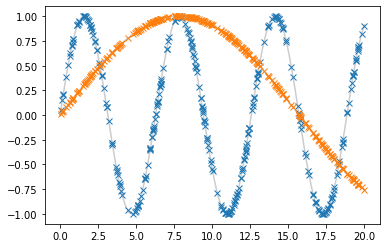

In [3]:
#  Ground truth latent function
def Gfn(X):
    G = np.empty((1, X.shape[0], k))
    G[0, :, 0] = np.sin(X)
    G[0, :, 1] = np.sin(X/5)
    return G


X_grid = 20*np.linspace(0,1, 500)

X = 20*np.sort(np.random.rand(N))
G = Gfn(X)
G_grid = Gfn(X_grid)


plt.figure()
plt.plot(X_grid, G_grid[0, ...], 'k-',alpha=.2)
plt.plot(X, G[0, ...], 'x')
    
# inducing point locations and make X and Z right shape
n_inducing = 40
Z = np.linspace(np.min(X), np.max(X), n_inducing)

### Combine the latents

In [4]:
A = np.random.rand(Bn, o, k)
def Afn(times):
    x = np.einsum('t,...ik->...tik', times, A)
    return x


B_gen = np.random.rand(k, k)
print(B_gen.shape)

# N data, k mixture outputs, 4 latents, m outputs per latent
W = np.einsum('...ij,jk->...ik', Afn(X), B_gen)
print(W.shape)
print(G.shape)
F = np.einsum('...tik,...tk->...ti', W, G)

likelihood_variance = 0.1 # oberservation noise variance.
eta = np.random.normal(np.zeros_like(F), likelihood_variance)
Y = F + eta

print(F.shape)
print(Y.shape)

(2, 2)
(1, 300, 5, 2)
(1, 300, 2)
(1, 300, 5)
(1, 300, 5)


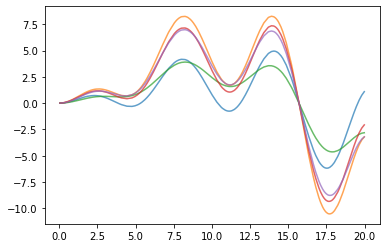

In [5]:
_ = plt.plot(X, F[0, ...], '-', alpha=1/np.sqrt(k))

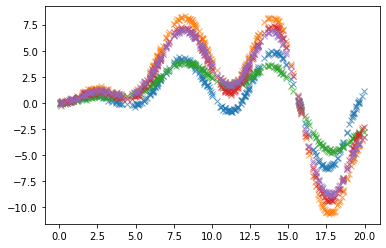

In [6]:
# Plot something, maybe use B = 2, plot B graphs.
_ = plt.plot(X, Y[0, ...], 'x', alpha=1/np.sqrt(k))

We now have X as our time data, F as our FA noiseless output, and G as our latent functions we will model with a GP prior

X is shape - batch (i.e. 1) x num data
Z is shape - batch (i.e. 1) x num inducing
Y is shape - batch (i.e. k == 10) x num data

We need to learn Bn == 3 GPs and combine them

## Fit the data and recover the latents

### Create a SVGP model using a GPFA kernel

In [7]:
import tensorflow as tf

from gpflow.likelihoods import Gaussian

from markovflow.models.sparse_variational import SparseVariationalGaussianProcess as SVGP
from markovflow.kernels import FactorAnalysisKernel

tf_X = tf.constant(np.repeat(X[None, :], Bn, axis=0), default_float())  # [Bn, N]
tf_Z = tf.constant(np.repeat(Z[None, :], Bn, axis=0), default_float())  # [Bn, N]
tf_Y = tf.constant(Y, default_float())  # [k, N, m]

tf_A = tf.constant(A)


def tf_Afn(times):
    x = tf.einsum('...t,...ik->...tik', times, tf_A)
    return x 


kernel = FactorAnalysisKernel(tf_Afn, kernels, o, True)

# Create the SVGP model
lik = Gaussian(likelihood_variance)

svgp = SVGP(kernel=kernel, inducing_points=tf_Z, likelihood=lik)

data = (tf_X, tf_Y)

print(tf_X.shape)
print(tf_Z.shape)
print(tf_Y.shape)

Instructions for updating:
Do not call `graph_parents`.


(1, 300)
(1, 40)
(1, 300, 5)


### Train the SVGP Factor analyis model

Everytime the ELBO starts to reduce we reduce the learning rate and continue

2022-01-12 11:28:25.685859: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
Use fn_output_signature instead


2022-01-12 11:28:53.022921: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-12 11:28:53.023872: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2095074999 Hz


2022-01-12 11:29:03.893796: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:906] Skipping loop optimization for Merge node with control input: SSMNaturalGradient/natural_gradient_steps/StatefulPartitionedCall/assert_equal_132/Assert/AssertGuard/branch_executed/_4964


0 tf.Tensor(-1098780.1710241968, shape=(), dtype=float64)
10 tf.Tensor(-563325.4406295245, shape=(), dtype=float64)


20 tf.Tensor(-340710.74738644314, shape=(), dtype=float64)
30 tf.Tensor(-239206.2679316933, shape=(), dtype=float64)


40 tf.Tensor(-189886.25969123965, shape=(), dtype=float64)
50 tf.Tensor(-163748.7831551616, shape=(), dtype=float64)


60 tf.Tensor(-147672.17471960935, shape=(), dtype=float64)
70 tf.Tensor(-135821.61911219487, shape=(), dtype=float64)


80 tf.Tensor(-125756.27916439912, shape=(), dtype=float64)
90 tf.Tensor(-116526.75568501875, shape=(), dtype=float64)


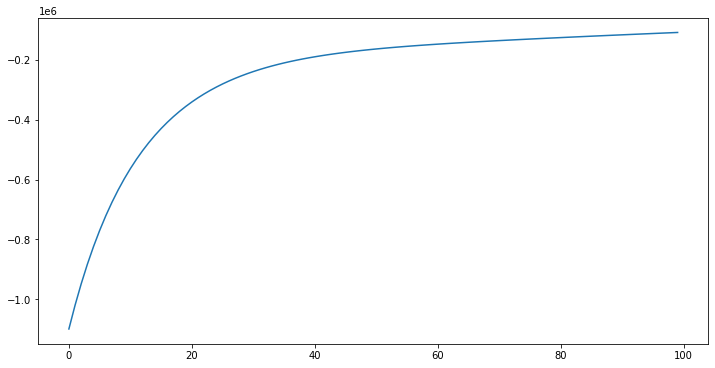

In [8]:
opt_ng = SSMNaturalGradient(.99)
opt_adam = tf.optimizers.Adam(0.01)

last_elbo = tf.Variable(0., dtype=default_float())


@tf.function
def loss():
    elbo = svgp.elbo(data)
    last_elbo.assign(elbo)
    return -elbo


@tf.function
def step():
    opt_adam.minimize(loss, svgp.kernel.trainable_variables)
    opt_ng.minimize(loss, ssm=svgp.dist_q)


elbos = []
max_iter = ci_niter(100)
for it in range(max_iter):
    step()
    elbos.append(last_elbo.value())
    if it % 10 == 0:
        print(it, last_elbo.value())


plt.figure(figsize=(12, 6))
plt.plot(elbos)

In [9]:
last_elbo = tf.Variable(0., dtype=default_float())

In [10]:
last_elbo

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.0>

### Generate the marginal means and variances

We do this at the training points for the latent and obervable processes

In [11]:
x_grid = np.linspace(X.min(), X.max(), 500)
X_grid = np.repeat(x_grid[None, :], Bn, axis = 0) # [Bn, N]
tf_X_grid = tf.constant(X_grid)


posterior = svgp.posterior
f_mus, f_covs = posterior.predict_f(X_grid)

In [12]:
print(f_mus.shape, f_covs.shape)
f_means = f_mus[0, ...]
f_vars = f_covs[0, ...]

(1, 500, 5) (1, 500, 5)


In [13]:
print(f_means.shape, f_vars.shape)

(500, 5) (500, 5)


### Plot the obervable processes

<Figure size 864x432 with 0 Axes>

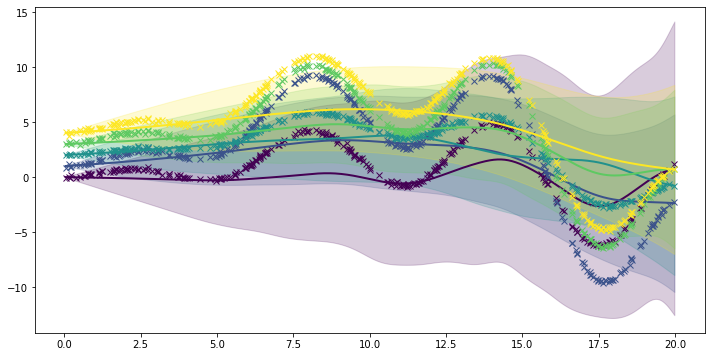

In [14]:
plt.figure(figsize=(12, 6))

f_means = f_mus[0,...]
f_vars = f_covs[0,...]

cmap = matplotlib.cm.get_cmap('viridis')
cols = cmap(np.linspace(0, 1, o))

plt.figure(figsize=(12, 6))
for ind in range(o):
    plt.plot(X,
             ind + Y[0, :, ind],
             color=cols[ind], marker='x', linestyle='none')
    
    m = f_means[..., ind]
    s = f_vars[..., ind]
    plt.plot(x_grid, ind + m, color=cols[ind], lw=2)
    lb = m - 2*np.sqrt(s)
    ub = m + 2*np.sqrt(s)
    plt.fill_between(x_grid, ind + lb, ind + ub, color=cols[ind], alpha=0.2)

### Plot the latents

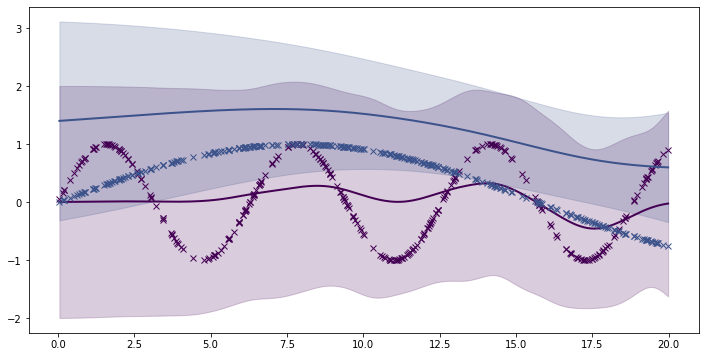

In [15]:
s_mus, s_covs = posterior.predict_state(X_grid)
latent_emission_model = svgp.kernel._latent_components.generate_emission_model(X_grid)
g_mus, g_covs = latent_emission_model.project_state_marginals_to_f(s_mus, s_covs)
g_means = g_mus[0, ...]
g_vars = g_covs[0, ...]

cmap = matplotlib.cm.get_cmap('viridis')
cols = cmap(np.linspace(0, 1, o))

plt.figure(figsize=(12, 6))
for ind in range(k):
    plt.plot(X,
             G[0, :, ind],
             color=cols[ind], marker='x', linestyle='none')
    
    m = g_means[..., ind]
    s = g_vars[..., ind]
    plt.plot(x_grid, ind + m, color=cols[ind], lw=2)
    lb = m - 2*np.sqrt(s)
    ub = m + 2*np.sqrt(s)
    plt.fill_between(x_grid, ind + lb, ind + ub, color=cols[ind], alpha=0.2)

In [16]:
print(g_mus.shape, g_vars.shape)

(1, 500, 2) (500, 2)
